In [5]:
#Registered index-linked annuities simulation and synthetic datasets
class OptionPricing:
    def __init__(self,S0,E,contract_duration,rf,sigma,iterations,premium_paid,buffer,participate,fee,cap):
        self.S0 = S0
        self.E = E
        self.contract_duration = contract_duration
        self.rf = rf
        self.sigma = sigma
        self.iterations = iterations
        self.premium_paid=premium_paid
        self.buffer=buffer
        self.participate=participate
        self.fee=fee
        self.cap=cap   
    def buffer_cap(self):
      T=0        #Year of the contract: if T is equal to the self.contract_duration, means that the policyholder survive at the end of the contract year
      num_stock=self.premium_paid/self.S0
      col=[]
      for p in range(0,self.contract_duration+1):
        col.append("year"+str(p))
      col=["buy_age","end_age"]+col+["final"]
      #hedging
      hedging=pd.DataFrame(index=np.arange(self.iterations),columns=["cost","payout","price"])
      #account value
      account_value_path=pd.DataFrame(index=np.arange(self.iterations),columns=col)
      #stock price
      stock_price_path=pd.DataFrame(index=np.arange(self.iterations),columns=col)
      #final value
      final_value=pd.DataFrame(index=["account value","stock price"],columns=col)
      final=[]
      for i in range(0,self.iterations):   
          age=random.randint(55,75)
          #determine the T(whether the policyholder can survive at the maturity)
          ind=life_table.loc[life_table["age"]==age].index[0]
          lst=[]
          for j in np.arange(0,self.contract_duration).astype(np.int64):
              m=random.randint(1,300000)/300000
              if m > life_table.iloc[int(ind+j)]["Death probabilities"]:
                lst.append(1)
              if m < life_table.iloc[int(ind+j)]["Death probabilities"]:
                T=sum(lst)
                break
              T=sum(lst)   
          #set the initial value
          stock_price=account_value=stock_price_path["year0"]=account_value_path["year0"]=self.S0
          account_value_path["buy_age"][i]=stock_price_path["buy_age"][i]=age/num_stock
          account_value_path["end_age"][i]=stock_price_path["end_age"][i]=(age+T)/num_stock
          rate=0
          #create the synthetic dataset
          for k in np.arange(1,T+1):
            stock_price=stock_price*(np.exp(1*(self.rf - 0.5*self.sigma**2) + self.sigma * np.sqrt(1) * np.random.normal(0,1)))           
            stock_price_path["year"+str(k)][i]=stock_price
            #calculate the return of the year
            rate=stock_price/stock_price_path["year"+str(k-1)][i]-1
            #adjust the return with guarantees
            rate=max(min(rate,self.cap),min(rate-self.buffer,0))*self.participate
            #calculate the account value
            account_value=account_value*(1+rate-self.fee)
            account_value_path["year"+str(k)][i]=account_value         
          #determine the payoffs
          if T==self.contract_duration:
            account_value_path["final"][i]=max(account_value_path["year"+str(T)][i],self.S0)
          else:
            account_value_path["final"][i]=account_value_path["year"+str(T)][i]
          #calculate the hedging costs
            #the call option price:
          call_st=Option(european=True,kind='call',s0=self.S0,k=self.S0,sigma=self.sigma,r=self.rf,t=self.contract_duration*365).getPrice()
          call_st_C=Option(european=True,kind='call',s0=self.S0,k=self.S0*(1+self.cap),sigma=self.sigma,r=self.rf,t=self.contract_duration*365).getPrice()
            #the put option price:
          put_st_B=Option(european=True,kind='put',s0=self.S0,k=self.S0*(1+self.buffer),sigma=self.sigma,r=self.rf,t=self.contract_duration*365).getPrice()         
          #calculate the hedging costs
          hedging["cost"][i]=(1-self.fee*self.contract_duration)*self.participate*(call_st-call_st_C)-(1-self.fee*self.contract_duration)*put_st_B
          #calculate the hedging payoffs:
          short_call=-max(stock_price_path["year"+str(T)][i]-self.S0*(1+self.cap),0)
          short_put=-max(self.S0*(1+self.buffer)-stock_price_path["year"+str(T)][i],0)
          long_call=max(stock_price_path["year"+str(T)][i]-self.S0,0)
          hedging["payout"][i]=(1-self.fee*self.contract_duration)*self.participate*(long_call-short_call)-(1-self.fee*self.contract_duration)*short_put
          #caculate the guarantees' price
          guarantee_price=(self.S0-hedging["cost"][i])*4.45%-self.S0*np.exp(-self.contract_duration*0.0445)
          hedging["price"][i]=guarantee_price
      #finish the final value dataset
      final_value["buy_age"][0],final_value["buy_age"][1],final_value["end_age"][0],final_value["end_age"][1]=account_value_path["buy_age"].mean(),stock_price_path["buy_age"].mean(),account_value_path["end_age"].mean(),stock_price_path["end_age"].mean()
      final_value["hedging_price"],final_value["hedging_cost"],final_value["hedging_payout"]=hedging["price"].mean(),hedging["cost"].mean()
      for l in range(0,self.contract_duration+1):    
        final_value["year"+str(l)][0]=account_value_path["year"+str(l)].mean()
        final_value["year"+str(l)][1]=stock_price_path["year"+str(l)].mean()
        final_value["final"]=account_value_path["final"].mean()

      return final_value.fillna(0)*num_stock,account_value_path*num_stock,stock_price_path*num_stock
for i in range(1,10):
  if __name__ == "__main__":

          S0=20                  #underlying
          E=21                   #strike Price
          contract_duration=6           #time to maturity
          rf=0.02                 #risk-free interest rate
          sigma=0.3                #volatility of the underlying
          iterations=1000             #number of Monte Carlo iterations
          premium_paid=10000            #The premium amount
          buffer=-0.15               #Buffer
          participate=0.95             #participate rate
          fee=0                  #Administration fee
          cap=0.10                 #cap
          model = OptionPricing(S0,E,contract_duration,rf,sigma,iterations,premium_paid,buffer,participate,fee,cap)
          buffer_cap=model.buffer_cap()

,buy_age,end_age,year0,year1,year2,year3,year4,year5,year6,final,hedging_price,hedging_cost,hedging_payout
account value,65.282,70.843,10000.0,9912.645739,9843.108532,9777.410478,9718.591233,9698.211635,9621.676550,10813.057719,-375.01862,-1125.890003,7966.326209
stock price,65.282,70.843,10000.0,10139.112464,10195.590110,10352.751721,10521.575242,10859.352992,11066.694122,10813.057719,-375.01862,-1125.890003,7966.326209


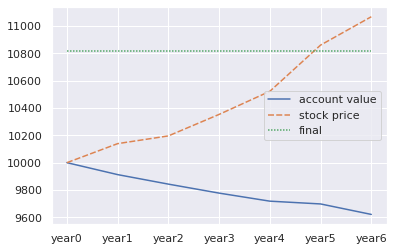

In [6]:
final_value,account_value,stock_price=buffer_cap
final_valuenew=final_value.T.rename(columns={0:"account_value",1:"stock_price"})[2:-4]
final_valuenew["final"]=final_value["final"][0]
sns.lineplot(data=final_valuenew)
final_value

In [7]:
stock_price.head()

,buy_age,end_age,year0,year1,year2,year3,year4,year5,year6,final
0,60.0,66.0,10000.0,15410.731424,19167.302433,17265.639322,18319.204951,22684.705461,22937.691287,NaN
1,62.0,68.0,10000.0,13365.855404,20936.771859,19433.857287,15711.019871,12586.747228,17623.844366,NaN
2,55.0,61.0,10000.0,12371.05874,13428.231391,13460.83917,13366.237782,11004.928718,9902.722945,NaN
3,67.0,73.0,10000.0,8546.073832,10062.265253,8809.085969,9762.585338,10156.367909,9796.386212,NaN
4,59.0,65.0,10000.0,12536.820061,16743.260632,12472.771449,17780.06605,21672.577675,18957.535694,NaN


In [8]:
account_value.head()

,buy_age,end_age,year0,year1,year2,year3,year4,year5,year6,final
0,60.0,66.0,10000.0,10950.0,11990.25,11990.25,12685.323568,13890.429307,14037.593556,14037.593556
1,62.0,68.0,10000.0,10950.0,11990.25,11990.25,11516.799538,10982.238716,12025.551395,12025.551395
2,55.0,61.0,10000.0,10950.0,11838.948855,11866.259952,11866.259952,11565.698308,11565.698308,11565.698308
3,67.0,73.0,10000.0,10000.0,10950.0,10950.0,11990.25,12449.705538,12449.705538,12449.705538
4,59.0,65.0,10000.0,10950.0,11990.25,10793.571007,11818.960253,12941.761477,12941.761477,12941.761477


In [ ]:
import numpy as np
import pandas as pd
import math
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson
import statistics
from optionprice import Option
from IPython.display import display
life_table=pd.read_csv("https://raw.githubusercontent.com/MasonQ813/Research/main/life%20table%20males.csv")
life_table.head()

In [13]:
import warnings
warnings.filterwarnings("ignore")
sns.set()

0

In [14]:
b

1